<a href="https://colab.research.google.com/github/KartikayBhardwaj-dev/COLLEGE/blob/main/week8_graded_1_2ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import pandas as pd
import numpy as np
import os , cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [20]:
! rm -f image_data/data/.DS_Store

IMAGE DATA TO WORKING DATA

In [21]:
! ls -a image_data/data

.  ..  with_mask  without_mask


In [28]:
def load_images(data_dir):
  images = []
  labels = []
  for root , _, files_list in os.walk(data_dir):
    for f in files_list:
      if f.lower().endswith(('png','jpg','jpeg')):
        img = cv2.imread(os.path.join(root,f),cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(100,100))/255.0
        images.append(img.flatten())
        labels.append(os.path.basename(root))
  images = np.array(images)
  labels = np.array(labels)
  return images , labels

In [29]:
images , labels = load_images('image_data/data')

In [45]:
np.unique(labels
          )

array(['with_mask', 'without_mask'], dtype='<U12')

In [34]:
np.sum(labels == "without_mask")

np.int64(3828)

TRAINING THE MODEL
- Training the model

* Encode the labels using LabelEncoder such that without_mask will be mapped to 1 and with_mask will be mapped to 0.

* Split the dataset with 20% datapoints for test set and keep the random_state to be 0.

* Train a LogisticRegression with

random_state=0, max_iter=500, tol=0.001, C=10

This is going to take some time. Hold tight!

How many false positive data points are there on test dataset? Consider "without_mask" to be positive class.

In [37]:
le = LabelEncoder()
mapped_labels = le.fit_transform(labels)

In [39]:
X_train , X_test , y_train , y_test = train_test_split(images , mapped_labels , test_size=0.2 , random_state=0)
lr = LogisticRegression(random_state=0, max_iter=500, tol=0.001, C=10)

In [40]:
lr.fit(X_train,y_train)

LogisticRegression(C=10, max_iter=500, random_state=0, tol=0.001)

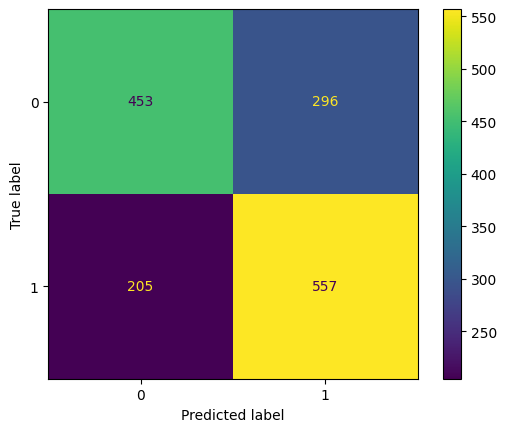

In [44]:
y_pred = lr.predict(X_test)
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

DATA AUGMENTATION
- Data Augmentation

Define a function named augment_image with the following parameters:

* images: a NumPy array of input images

* labels: a NumPy array of labels corresponding to the input images

* angles: a NumPy array of shape (augmentation_factor * len(images),) containing rotation angles (in degrees) for each augmented image

* augmentation_factor: an integer specifying how many augmented images to generate per input image

The function should:

* Create new images by rotating each input image using the corresponding angle from angles

* Return two arrays:

* augmented_images: a NumPy array containing the original and augmented images

* augmented_labels: a NumPy array containing the corresponding labels (original and augmented)

Constraints:

* Use np.random.seed(0) to ensure reproducibility.

* Generate a NumPy array named angle_of_rotation with shape (augmentation_factor * len(images),) using uniform sampling from
−
180
∘
−180
∘
  to
180
∘
180
∘
 .

* Ensure that all images, including augmented ones, retain the original shape:
100
×
100
100×100.

Tasks:

* Call the augment_image function using your training data and the generated angle_of_rotation, with augmentation_factor = 2.

* Compute the sum of elements in augmented_labels from index 7000 to 8000 (inclusive of index 7000 and exclusive of 8000, i.e., using Python’s zero-based indexing and slicing).

In [46]:
def augment_image(images, labels, angles, augmentation_factor):
    augmented_images = []
    augmented_labels = []

    idx = 0  # to track which angle to use

    for image, label in zip(images, labels):
        # Add original image and label
        augmented_images.append(image)
        augmented_labels.append(label)

        # Add augmented images
        for _ in range(augmentation_factor):
            angle = angles[idx]
            idx += 1

            img = Image.fromarray((image.reshape((100, 100)) * 255).astype(np.uint8))
            img_rotated = img.rotate(angle)

            rotated_array = np.array(img_rotated).reshape(-1) / 255.0
            augmented_images.append(rotated_array)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)


In [47]:
np.random.seed(0)
augmentation_factor = 2
angle_of_rotation = np.random.uniform(-180, 180, size=(augmentation_factor * len(X_train),))
aug_images , aug_labels = augment_image(X_train,y_train,angle_of_rotation,augmentation_factor)

In [48]:
np.sum(aug_labels[7000:8000])

np.int64(527)

Feature selection using RandomForest

Perform RandomForestClassifier with random_state=0 on the augmented training dataset. Select the top 100 features (impurity-based feature importances) using appropriate RandomForestClassifier attribute. Now using the selected top 100 feautures, fit the model on augmented training data and find the number of missclassified data points/images from the test data.

In [53]:
# Step 1: Reshape augmented images to 2D (samples, features)
X_aug = aug_images.reshape((aug_images.shape[0], -1))
y_aug = aug_labels

# Step 2: Train RandomForest on all features
rf = RandomForestClassifier(random_state=0)
rf.fit(X_aug, y_aug)

# Step 3: Get top 100 important features
importances = rf.feature_importances_
top_100_indices = np.argsort(importances)[-100:]

# Step 4: Select top 100 features from augmented training and test sets
X_aug_top100 = X_aug[:, top_100_indices]
X_test_reshaped = X_test.reshape((X_test.shape[0], -1))
X_test_top100 = X_test_reshaped[:, top_100_indices]

# Step 5: Train on selected features
rf_top100 = RandomForestClassifier(random_state=0)
rf_top100.fit(X_aug_top100, y_aug)

# Step 6: Predict and calculate misclassifications
y_pred = rf_top100.predict(X_test_top100)
misclassified_count = np.sum(y_pred != y_test)

print("Number of misclassified test images:", misclassified_count)

KeyboardInterrupt: 